# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, sum, split, udf, isnan, when, count, countDistinct
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window
import datetime
from pyspark.sql.functions import date_format

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("capstone_project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
data = "mini_sparkify_event_data.json"
df = spark.read.json(data)
#df.persist()

In [5]:
# check the structure and column names of the dataset
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# check the first row to see what the data looks like
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [7]:
# count the number of rows
print(df.count())

# count the number of columns
print(len(df.columns))

286500
18


In [8]:
# count the number of nan values in each column
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [9]:
# count the number of null values in each column
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [10]:
# Check the number of empty values in two columns: "userId" and "sessionId"
print(df.filter(df.userId == "").count())
print(df.filter(df.sessionId == "").count())

8346
0


In [11]:
# As the above cell results suggest, we have empty userId values in some rows, but we do not have any empty sessionId values
# So I drop the rows with empty values in "userId" and "sessionId" columns
df = df.select("*").where((df.userId != ""))
print(df.count())

278154


In [12]:
# check if the rows where artist value is null, has "NextSong" value in page column:
#df.where(col("artist").isNull()).count()
print(df.where((df.artist.isNull()) & (df.page == "NextPage")).count())
print(df.where(df.artist.isNull()).show(n=2))
df.where(df.artist.isNull()).select("page").dropDuplicates().sort("page").show()

0
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
+------+---------+---------+

I can see from the example above that rows with empty artist values are exempt from having artist values since they are unrelated to song plays. I do not need to drop these rows because of this.

In [13]:
# Check the different options for "page" column:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [14]:
# Count the number of null values in each column once again:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [15]:
# Change the time format of ts and registration in the dataframe
change_time_format = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("tsDateColumn", change_time_format(df.ts))
df = df.withColumn("registrationDateColumn", change_time_format(df.registration))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [16]:
# Check the number of users in the dataset
print(df.select("userId").dropDuplicates().count())

# Check the number of users who has "Cancellation Confirmation" in the dataset
print(df.select("userId").where(df.page == "Cancellation Confirmation").dropDuplicates().count())

# Check the number of users who has "Downgrade" in the dataset
print(df.select("userId").where(df.page == "Downgrade").dropDuplicates().count())

225
52
154


#### Definition of Churn

When a client downgrades or cancels their subscription, this is referred to as churn. Churn essentially reduces a company's subscribed user base, which has a detrimental impact on profit.

Companies try to detect the customers who have a potential to churn and give additional offers to these customers. This is why it is important to have a precise model for detecting churn.

There are 225 users in total in the dataset, according to my examination of the provided dataset. There are 154 users with "Downgrade" and 52 people with "Cancellation Confirmation." Since the bulk of customers would then be classified as Churn users, I do not prefer to add Downgrade to Churn. Because of this, I refer to people who have "Cancellation Confirmation" in the dataset as "Churn."

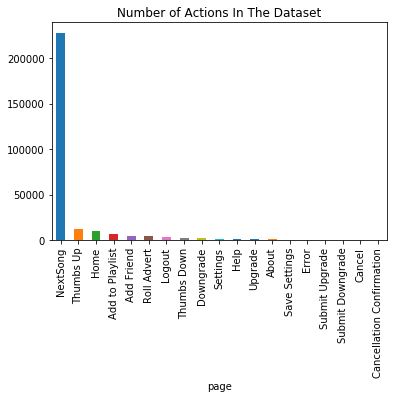

In [17]:
# Check the number of each action in the dataset
action_counts = df.groupby("page").count().sort(desc("count")).toPandas()
action_counts.plot.bar(x='page', y='count', legend=None)
plt.title('Number of Actions In The Dataset');
plt.show()

In [18]:
# Since I defined churn as users who has cancellation confirmation in the dataset I add a new column
# named "churnInfo" as a flag for the the customers who churned.

# Find the customers who has a "Cancellation Confirmation"
churn_find = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churnInfo", churn_find("page"))

# Flag all the rows for the customers who churned.
churn_window = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("churnInfo", max("churnInfo").over(churn_window))

In [19]:
# Check a few users who churned
df.select("userId").where(df.page == "Cancellation Confirmation").dropDuplicates().show(n=2)

+------+
|userId|
+------+
|   125|
|    51|
+------+
only showing top 2 rows



In [20]:
# Compare the number of rows and the number of churn flags for a specific user who churned
print(df.select("*").where(df.userId == "51").orderBy(desc("ts")).count())
print(df.select("*").where((df.userId == "51") & (df.churnInfo == 1)).orderBy(desc("ts")).count())

2464
2464


#### Most Popular Artists and Songs

In [21]:
# Most popular 5 'artist's are:
df.groupby('artist').agg(count('artist')).orderBy(desc('count(artist)')).show(n=5)

+--------------------+-------------+
|              artist|count(artist)|
+--------------------+-------------+
|       Kings Of Leon|         1841|
|            Coldplay|         1813|
|Florence + The Ma...|         1236|
|       Dwight Yoakam|         1135|
|            BjÃÂ¶rk|         1133|
+--------------------+-------------+
only showing top 5 rows



In [22]:
# Most popular 5 'song's are:
df.groupby('song').agg(count('song')).orderBy(desc('count(song)')).show(n=5)

+--------------------+-----------+
|                song|count(song)|
+--------------------+-----------+
|      You're The One|       1153|
|                Undo|       1026|
|             Revelry|        854|
|       Sehr kosmisch|        728|
|Horn Concerto No....|        641|
+--------------------+-----------+
only showing top 5 rows



#### Number of Songs Played Analysis

In [23]:
# The number of songs played by two different groups: the ones who churned and the ones who did not churn
df.select("*").where(df.page == "NextSong").groupby("churnInfo").agg(count("churnInfo")).show()

+---------+----------------+
|churnInfo|count(churnInfo)|
+---------+----------------+
|        1|           36394|
|        0|          191714|
+---------+----------------+



+---------+-------------------------------------------+
|churnInfo|(count(churnInfo) / count(DISTINCT userId))|
+---------+-------------------------------------------+
|        1|                          699.8846153846154|
|        0|                         1108.1734104046243|
+---------+-------------------------------------------+

None


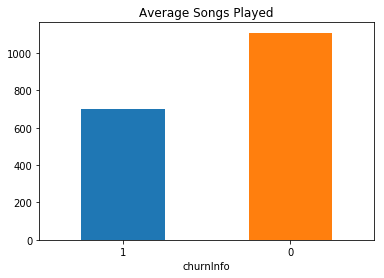

In [24]:
# But it is better to find the average number of songs played for each group:
print(df.select("*").where(df.page == "NextSong").groupby("churnInfo").agg(count("churnInfo")/countDistinct("userId")).show())

avg_songs_played = df.select("*").where(df.page == "NextSong") \
                                .groupby("churnInfo").agg(count("churnInfo")/countDistinct("userId")).toPandas()

avg_songs_played.plot.bar(x='churnInfo', y='(count(churnInfo) / count(DISTINCT userId))', rot=0, legend= None)
plt.title('Average Songs Played');
plt.show()

#### Gender Analysis

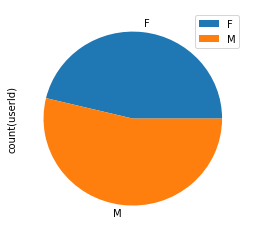

In [25]:
# Lets check the gender distribution in the dataset
gender_distribution = df.dropDuplicates(['userId']).groupby('gender').agg(count('userId')).toPandas()
gender_distribution.set_index('gender').plot.pie(y='count(userId)', figsize=(4, 4))

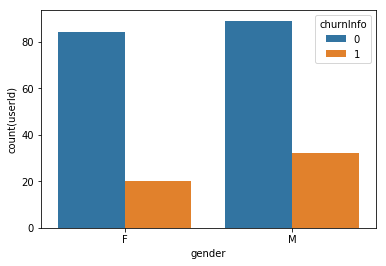

In [26]:
# Lets compare the genders of customers who churned and did not churn
churn_by_gender = df.dropDuplicates(['userId']).groupby(['churnInfo', "gender"]).agg(count('userId')).toPandas()
sns.barplot(data = churn_by_gender, x='gender', y='count(userId)', hue='churnInfo')

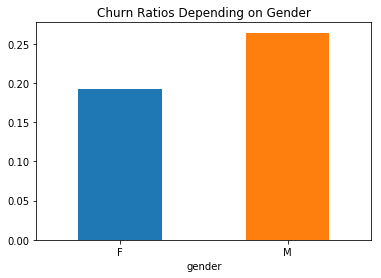

In [27]:
# The bar chart above shows that male have a more tendency to churn compared to female.
# Lets see this in percentages:
churn_percent_by_gender = df.dropDuplicates(['userId']).groupby(["gender"]).agg(sum('churnInfo')/count('userId')).toPandas()

churn_percent_by_gender.plot.bar(x='gender', y='(sum(churnInfo) / count(userId))', rot=0, legend= None)
plt.title('Churn Ratios Depending on Gender');
plt.show()

The above chart states that gender might have an effect on churn.

#### Level Analysis

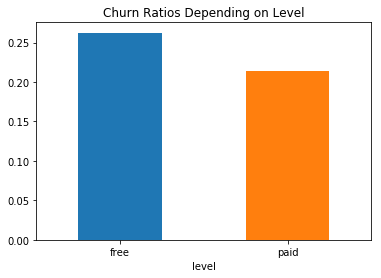

In [28]:
# Lets check if level difference (free or paid) has an effect on churn:
churn_percent_by_level = df.dropDuplicates(['userId']).groupby(["level"]).agg(sum('churnInfo')/count('userId')).toPandas()

churn_percent_by_level.plot.bar(x='level', y='(sum(churnInfo) / count(userId))', rot=0, legend= None)
plt.title('Churn Ratios Depending on Level');
plt.show()

The above chart states that level might have an effect on churn. Paid users churn less compared to free customers.

#### "length" Column

In [29]:
df.select('length').where(df.page == 'NextSong').show(n=10)

+---------+
|   length|
+---------+
|277.89016|
|236.09424|
| 282.8273|
|262.71302|
|223.60771|
|208.29995|
|260.46649|
|185.44281|
|134.47791|
| 229.8771|
+---------+
only showing top 10 rows



In [30]:
# Check the statistics of "length" column
df.describe('length').show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [31]:
# Check if "length" is the length of the song, or how long a song played before skipped to the next song.
# Since the result of count of Distinct length is more than 1, the lenght shows how long the song was played for each
# customer

df.select("*").where(df.page == 'NextSong').groupby('song').agg(countDistinct('length'), count('song')) \
                                                                .orderBy(desc('count(DISTINCT length)')).show()

+----------+----------------------+-----------+
|      song|count(DISTINCT length)|count(song)|
+----------+----------------------+-----------+
|     Intro|                    50|         92|
|      Home|                    22|        224|
|   Hold On|                    19|         50|
| Beautiful|                    18|         61|
|   Goodbye|                    17|         48|
|   Someday|                    17|         86|
|   Lullaby|                    16|         50|
|      Stay|                    16|         72|
|   Wake Up|                    16|         32|
|   Tonight|                    16|         53|
|     Smile|                    15|         84|
|Everything|                    15|         62|
|     Hello|                    15|         97|
|       You|                    15|         32|
|     Angel|                    14|         65|
|   Believe|                    14|         35|
|      Gone|                    14|         57|
|    Heaven|                    14|     

I'll use the number of songs played for each customer in the churn model. Each customer's total song length will be associated with the number of songs listened. I won't use length for the machine learning model because of this.

#### "status" Column

In [32]:
# check the different options for "status" column:
df.select("status").dropDuplicates().sort("status").show()

+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+



#### Number of Songs in Each Hour Analysis

In [33]:
# I would like to check the number of songs that were listened in each hour of the day on average

# Define a UDF to find the hour of day in the dataframe and use the function to create a new column named "hour_of_day"
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).hour)
df = df.withColumn("hour_of_day", get_hour(df.ts))

In [34]:
# Count the number of songs in each hour of day and store it in a pandas dataframe
songs_by_hour = df.select(['song', 'hour_of_day']).where(df.page == 'NextSong').groupby('hour_of_day').agg(count('song')) \
                                                                                    .orderBy('hour_of_day').toPandas()

# Change the datatype of "hour_of_day" column to integer and sort the rows on this column
songs_by_hour = songs_by_hour.astype({"hour_of_day": int})
songs_by_hour = songs_by_hour.sort_values(by='hour_of_day').reset_index(drop=True)

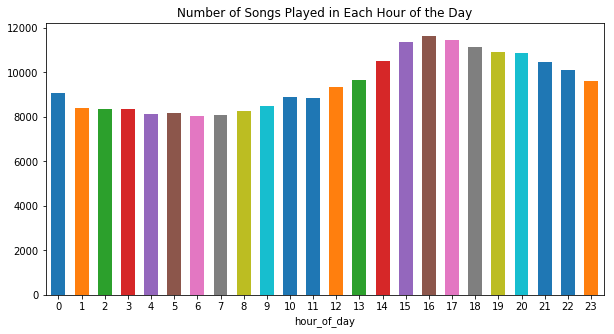

In [35]:
# Plot a chart to visualize the results
songs_by_hour.plot.bar(x='hour_of_day', y='count(song)', rot=0, legend= None, stacked=True, width=0.6, figsize=(10, 5))
plt.title('Number of Songs Played in Each Hour of the Day');
plt.show()

The above chart shows that maximum number of songs are played between 15 and 17 in the afternoon.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Features From "page"

In [36]:
# Here I define a function to extract features from the page column depending on different page categories
def feature_from_page(df, page_category):
    output = df.filter(df.page == page_category).groupby('userId') \
                .agg(count('page')).withColumnRenamed('count(page)', page_category)
    return output

# I make a list of the page categories I would like to add to my features dataframe
features_from_page_list = ['Add Friend', 'Add to Playlist', 'Thumbs Down',
                           'Thumbs Up', 'Error', 'Home', 'Roll Advert']

In [37]:
# I create a features dataframe.
features_df = df.select('userId').dropDuplicates()

# I add different features from the page column into features dataframe, I make outer join, in case I have null values
# I plan to fill them with zero values.
for feat in features_from_page_list:
    output = feature_from_page(df, feat)
    features_df = features_df.join(output, 'userId', 'outer')

#### Features From "df columns"

##### Add feature: gender

In [38]:
# Define a user-defined function to create a new column to change categorical "gender" column to numeric.
gender_adder = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
# Apply the udf to create a new numeric "gender" column
df = df.withColumn('isMale', gender_adder(df.gender))

# Take the userId info and gender for adding the gender info into features dataframe
genders_of_users = df.dropDuplicates(['userId']).select(['userId', 'isMale']) \
                                                                .groupby('userId').agg(max('isMale')) \
                                                                .withColumnRenamed('max(isMale)', 'isMale')

# add the gender column into features dataframe
features_df = features_df.join(genders_of_users, 'userId', 'outer')

##### Add feature: level

In [39]:
# Define a user-defined function to create a new column to change categorical "level" column to numeric.
level_adder = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
# Apply the udf to create a new numeric "level" column
df = df.withColumn('isPaid', level_adder(df.level))

# Take the userId info and level for adding the level info into features dataframe
levels_of_users = df.dropDuplicates(['userId']).select(['userId', 'isPaid']) \
                                                                .groupby('userId').agg(max('isPaid')) \
                                                                .withColumnRenamed('max(isPaid)', 'isPaid')

# add the level column into features dataframe
features_df = features_df.join(levels_of_users, 'userId', 'outer')

##### Add feature: number of songs played

In [40]:
# Take the userId and number of songs they played
number_of_songs = df.select(['userId', 'page']).where(df.page == 'NextSong') \
                                .groupby('userId') \
                                .agg({'page':'count'}) \
                                .withColumnRenamed('count(page)', 'numberOfSongsPlayed')

# Add the number of songs column into features dataframe
features_df = features_df.join(number_of_songs, 'userId', 'outer')

##### Add feature: membership duration

In [41]:
# I would like to add the membership duration for each of the users in the dataset
membership_duration_days = df.select(['userId', 'ts', 'registration']) \
                             .withColumn('membership_duration', (df.ts - df.registration)/(1000*60*60*24)) \
                                .groupby('userId') \
                                .agg({'membership_duration': 'max'}) \
                                .withColumnRenamed('max(membership_duration)', 'membership_duration')

# Add the duration of membership column into features dataframe
features_df = features_df.join(membership_duration_days, 'userId', 'outer')

##### Add churnInfo as label 

In [42]:
# Take the userId and churnInfo for adding into features dataframe as a label
churn_label = df.dropDuplicates(['userId']).select(['userId', 'churnInfo']) \
                                                                .groupby('userId').agg(max('churnInfo')) \
                                                                .withColumnRenamed('max(churnInfo)', 'churnInfo')

# Add the number of songs column into features dataframe
features_and_label_df = features_df.join(churn_label, 'userId', 'outer')

In [43]:
# Fill the null values in the features dataframe with zero values
features_and_label_df = features_and_label_df.fillna(0)

In [44]:
features_and_label_df.show(n=10)

+------+----------+---------------+-----------+---------+-----+----+-----------+------+------+-------------------+-------------------+---------+
|userId|Add Friend|Add to Playlist|Thumbs Down|Thumbs Up|Error|Home|Roll Advert|isMale|isPaid|numberOfSongsPlayed|membership_duration|churnInfo|
+------+----------+---------------+-----------+---------+-----+----+-----------+------+------+-------------------+-------------------+---------+
|100010|         4|              7|          5|       17|    0|  11|         52|     0|     0|                275|  55.64365740740741|        0|
|200002|         4|              8|          6|       21|    0|  20|          7|     1|     0|                387|  70.07462962962963|        0|
|   125|         0|              0|          0|        0|    0|   0|          1|     1|     0|                  8|  71.31688657407408|        1|
|   124|        74|            118|         41|      171|    6| 176|          4|     0|     1|               4079| 131.55591435185

In [45]:
# I make a list of features names I would like to vectorize in the dataset
features = ['Add Friend', 'Add to Playlist', 'Thumbs Up', 'Thumbs Down', 'Error', 'Home',
            'Roll Advert', 'isMale', 'isPaid', 'numberOfSongsPlayed', 'membership_duration']

# I create the vector assembler and use it to vectorize the feature
assembler = VectorAssembler(inputCols = features, outputCol = 'vectorized_Features')
features_and_label_df = assembler.transform(features_and_label_df)

In [46]:
# I scale the features in the dataset 
scaler = StandardScaler(inputCol = 'vectorized_Features', outputCol = 'scaled_vectorized_feaures')
scalerModel = scaler.fit(features_and_label_df)
features_and_label_df = scalerModel.transform(features_and_label_df)

In [47]:
# I create the data that I will be using to train and test my model. The model_date consists of two parts:
    # 1. vectorized and scaled features
    # 2. labels
model_data = features_and_label_df.select(features_and_label_df['scaled_vectorized_feaures'].alias("features"),
                                         features_and_label_df['churnInfo'].alias("label"))

In [48]:
model_data.show(n=5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.19434724774254...|    0|
|[0.19434724774254...|    0|
|(11,[6,7,9,10],[0...|    1|
|[3.59542408323712...|    0|
|[1.36043073419783...|    1|
+--------------------+-----+
only showing top 5 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [49]:
# Break the dataset into training and testing sets
train, test = model_data.randomSplit([0.8, 0.2], seed=42)

We can use f1 score as an indication to assess the accuracy of various algorithms because we have a classification problem and a short dataset.

In [50]:
# Create a single evaluator for comparing accuracy of different algoritms I train in the following cells
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')

##### Random Forest Classifier

In [51]:
# Define the model
rf = RandomForestClassifier()

# Define the parameter alternatives to be tested
paramGrid_rf = ParamGridBuilder() \
            .addGrid(rf.numTrees, [20, 30]) \
            .addGrid(rf.maxDepth, [5, 10]) \
            .build()


# Define cross-validation
crossval_rf = CrossValidator(estimator = rf,
                          estimatorParamMaps = paramGrid_rf,
                          evaluator = evaluator,
                          numFolds =3)

# Train the model with train dataset
rf_model = crossval_rf.fit(train)

# Make predictions with the model, by using test dataset
rf_preds = rf_model.transform(test)

# Calculate the f1-score accuracy to compare the performance of the model with other models. 
rf_f1_score = evaluator.evaluate(rf_preds)
print('Random Forest F1-Score: {}'.format(round(rf_f1_score*100,2)))

Random Forest F1-Score: 87.4


##### Logistic Regression Classifier

In [52]:
# Define the model
lr = LogisticRegression(elasticNetParam=0)

# Define the parameter alternatives to be tested
paramGrid_lr = ParamGridBuilder() \
            .addGrid(lr.regParam, [0.0, 0.1]) \
            .addGrid(lr.maxIter, [10, 50]) \
            .build()


# Define cross-validation
crossval_lr = CrossValidator(estimator = lr,
                          estimatorParamMaps = paramGrid_lr,
                          evaluator = evaluator,
                          numFolds =3)

# Train the model with train dataset
lr_model = crossval_lr.fit(train)

# Make predictions with the model, by using test dataset
lr_preds = lr_model.transform(test)

# Calculate the f1-score accuracy to compare the performance of the model with other models.
lr_f1_score = evaluator.evaluate(lr_preds)
print('Logistic Regression F1-Score: {}'.format(round(lr_f1_score*100,2)))

Logistic Regression F1-Score: 75.97


##### Gradient-Boosted Tree Classifier

In [ ]:
# Define the model
gbt = GBTClassifier()

# Define the parameter alternatives to be tested
paramGrid_gbt = ParamGridBuilder() \
            .addGrid(gbt.maxDepth, [5, 10]) \
            .addGrid(gbt.maxIter, [10, 20]) \
            .build()
        

# Define cross-validation
crossval_gbt = CrossValidator(estimator = gbt,
                        estimatorParamMaps = paramGrid_gbt,
                        evaluator = evaluator,
                        numFolds =3)

# Train the model with train dataset
gbt_model = crossval_gbt.fit(train)

# Make predictions with the model, by using test dataset
gbt_preds = gbt_model.transform(test)

# Calculate the f1-score accuracy to compare the performance of the model with other models.
gbt_f1_score = evaluator.evaluate(gbt_preds)
print('Gradient-Boosted Tree F1-Score: {}'.format(round(gbt_f1_score*100,2)))

#### Linear SVC Classifier

In [ ]:
# Define the model
lsvc = LinearSVC()

# Define the parameter alternatives to be tested
paramGrid_lsvc = ParamGridBuilder() \
            .addGrid(lsvc.regParam, [0.01]) \
            .addGrid(lsvc.maxIter, [5]) \
            .build()
        

# Define cross-validation
crossval_lsvc = CrossValidator(estimator = lsvc,
                          estimatorParamMaps = paramGrid_lsvc,
                          evaluator = evaluator,
                          numFolds =3)


# Train the model with train dataset
lsvc_model = crossval_lsvc.fit(train)

# Make predictions with the model, by using test dataset
lsvc_preds = lsvc_model.transform(test)

# Calculate the f1-score accuracy to compare the performance of the model with other models.
lsvc_f1_score = evaluator.evaluate(lsvc_preds)
print('Linear SVC F1-Score: {}'.format(round(lsvc_f1_score*100,2)))

As can be seen above, I used four different classification algorithms for churn model:
- Random Forest Classification
- Logistic Classification
- Gradient-Boosted Tree Classification
- Linear SVC Classification

The worst model (Linear SVC Classification) had an f1-score around 55 percent. But other three models give us that have better performances and the highest performance is from Random Forest Classification with 87 percent. Logistic Classification and Gradient-Boosted Classification is around 76 percent

We can think about including more features to raise the f1 score and create a better model. The typical amount of songs a user listens to each day, for instance, can be a useful feature. This is due to the possibility that the average daily song count could be a sign of how frequently a client uses the service.

Another clue could be the quantity of skipped songs—those that the user did not listen to all the way through. Churning can occur, for instance, if a user ignores a lot of the service's suggested songs because they are unsatisfied with them.

Finding innovative ways to identify the features that will allow us to train a better model is the most difficult aspect of the project. I identified 11 features, but as we consider our options, there are likely many more that would improve the model's accuracy.

Finding the settings that would improve accuracy through parameter adjustment was another challenge. It became harder to wait for the training process as the model training duration increased as I raised the amount of parameter tuning alternative options.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

githup : https://github.com/velespit/Project_4_Data-Scientist-Capstone <br>
medium : https://medium.com/@volkanaydogmusvg/sparkify-project-75d51a69df1f <br>